<a href="https://colab.research.google.com/github/Sapienza-AI-Lab/esercitazione6-22-23-soluzioni/blob/main/Exercise2.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

# Esercizio 2
In questo esercizio utilizzerete il dataset Heart Disease per costruire un modello in grado di predire se un paziente ha o meno una malattia cardiaca. Il dataset è composto da 303 pazienti, ognuno dei quali è descritto da 13 attributi. L'attributo target è un valore intero che va da 0 (assenza) a 4.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Caricamento del dataset

Attributes:
* Age
* Sex:
    * Male -> 1
    * Female -> 0
* Chest Pain Type: 
    * angina -> 1
    * abnang -> 2
    * notang -> 3
    * asympt -> 4
* Resting Blood Pressure
* Cholesterol
* Fasting Blood Sugar:
    * < 120 -> 1
    * \>= 120 -> 0
* Resting ECG:
    * norm -> 0
    * abn -> 1
    * hyper -> 2
* Max Heart Rate
* Exercise Induced Angina:
    * yes -> 1
    * no -> 0
* Oldpeak
* Slope:
    * up -> 1
    * flat -> 2
    * down -> 3
* Number of vessels colored
* Thal:
    * norm -> 3
    * fixed -> 6
    * rever -> 7
* Target:
    * 0 -> no disease
    * 1,2,3,4 -> disease



In [2]:
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']
xcols = cols[0:-1]
ycol = cols[-1]
df = pd.read_csv('data/processed.cleveland.data', header=None, index_col=None, names=cols, na_values=['?'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
df = df.dropna()

In [6]:
X = df[xcols]
m, n = X.shape

# Binarize the target
y = (df[ycol] > 0).astype(int)

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Normalize the data
normalize = True

if normalize:
    xmean = X_train.mean()
    xstd = X_train.std()
    # Note that we use the mean and std of the training set to normalize both the training and test sets
    X_train = (X_train - xmean)/xstd
    X_test = (X_test - xmean)/xstd

### Define the model

In [9]:
# Define logistic regression model
model = LogisticRegression(solver='lbfgs', n_jobs=-1)

### Grid Search

In [10]:
# Define scorer
scorer = make_scorer(accuracy_score)

# Define grid search parameters
grid = dict()
grid['C'] = np.logspace(-6, 3, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scorer, error_score=0)

In [11]:
# Perform grid search
start = time.time()
grid_result = grid_search.fit(X_train, y_train)
end = time.time()
print('Grid search time =', end - start)

Grid search time = 1.2323896884918213


In [12]:
# Summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.822961 using {'C': 0.1}
0.523227 (0.008011) with: {'C': 1e-06}
0.523227 (0.008011) with: {'C': 1e-05}
0.523227 (0.008011) with: {'C': 0.0001}
0.801773 (0.015547) with: {'C': 0.001}
0.818617 (0.041322) with: {'C': 0.01}
0.822961 (0.057372) with: {'C': 0.1}
0.822961 (0.057372) with: {'C': 1.0}
0.818794 (0.060182) with: {'C': 10.0}
0.818794 (0.060182) with: {'C': 100.0}
0.818794 (0.060182) with: {'C': 1000.0}


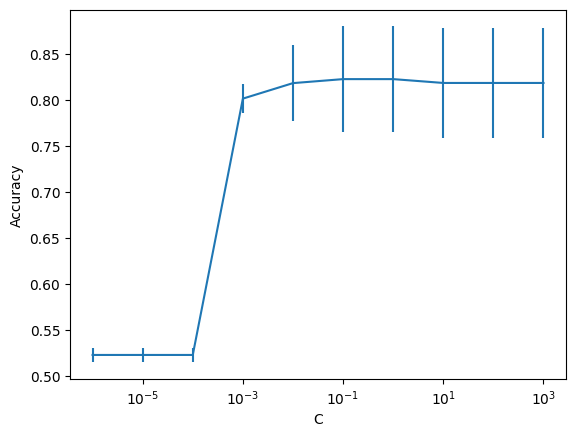

In [13]:
# Plot grid search results
plt.errorbar(grid['C'], means, yerr=stds)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [14]:
# Define logistic regression model with best parameters
model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=grid_result.best_params_['C'])

### Learning Curves

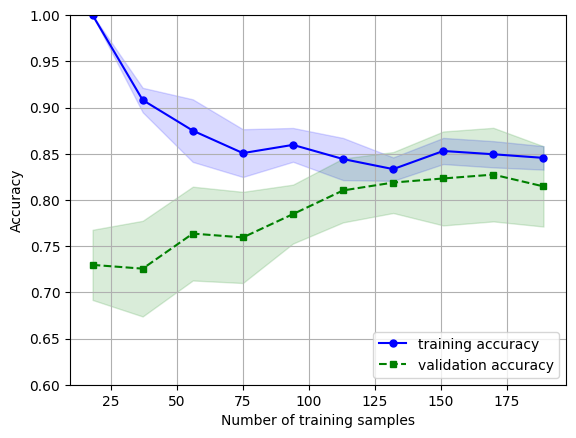

In [15]:
# Plot learning curve
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.show()

### Train

In [16]:
# Fit model on all training data
model.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1)

### Test

In [17]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy =', accuracy)

Test accuracy = 0.9


### Plot model coefficients

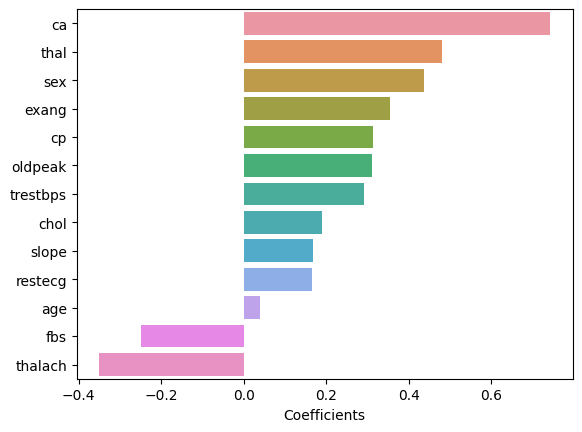

In [18]:
# Plot model coefficients
coeffs = pd.DataFrame(model.coef_, columns=xcols)
coeffs = coeffs.transpose()
coeffs.columns = ['Coefficients']
coeffs = coeffs.sort_values(by='Coefficients', ascending=False)
sns.barplot(x=coeffs['Coefficients'], y=coeffs.index)
plt.show()

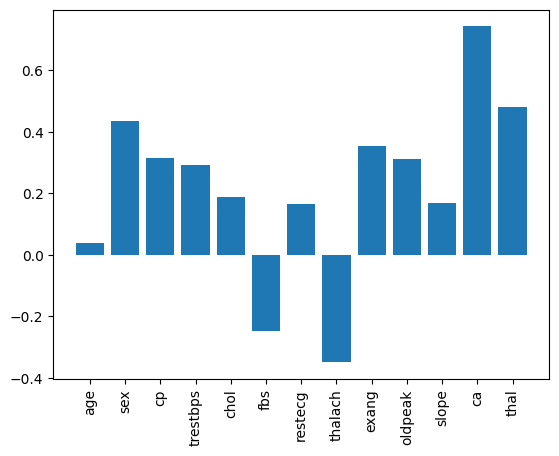

In [19]:
# Plot model coefficients without using only matplotlib
plt.bar(range(n), model.coef_[0])
plt.xticks(range(n), xcols, rotation=90)
plt.show()

# Task: Ripetete l'analisi e l'addestramento sul dataset YearPredictionMSD:

Il dataset Year Prediction MSD si puà scaricare da questo link: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

![YPMSD](data/ypmsd.jpg)
- **Nota 1:** Il dataset è molto grande. Per testare la procedura di analisi e la correttezza del codice, prima
provate su un sottoinsieme dei dati.
- **Nota 2:** Il problema può essere trattato come un problema di classificazione o di regressione. Voi iniziate a risolverlo come classificazione, poi, se volete, potete provare a risolverlo come regressione.